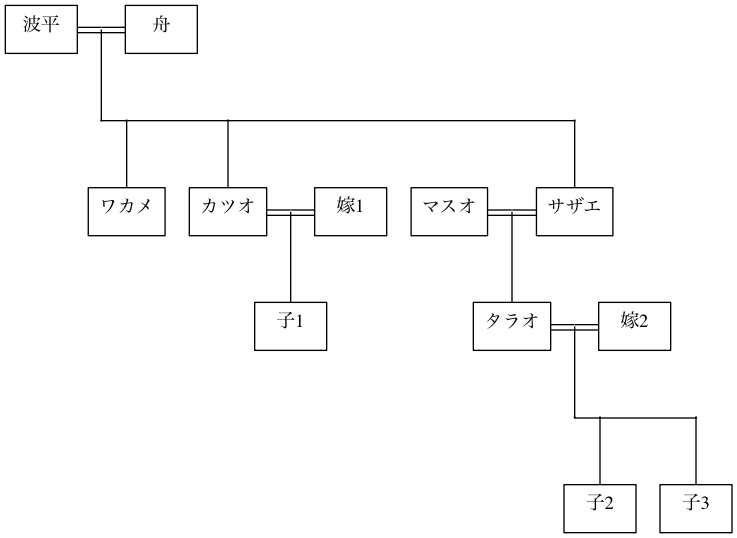

In [1]:
# -*- coding: utf-8 -*-
from collections import defaultdict
from graphviz import Digraph


def create_family_graph():
    """**Edit this function to create your own family tree.**

    Returns:
        A FamilyNetwork object representing your relatives to visualize.
    """
    families = FamilyNetwork()
    families.add_family(Couple('波平', '舟', 0), Children(['ワカメ', 'カツオ', 'サザエ']))
    families.add_family(Couple('マスオ', 'サザエ', 1), Children(['タラオ']))
    families.add_family(Couple('カツオ', '嫁1', 1), Children(['子1']))
    families.add_family(Couple('タラオ', '嫁2', 2), Children(['子2', '子3']))
    return families


class Couple(object):
    def __init__(self, husband, wife, generation):
        """
        Parameters:
            husband: The name of the husband.
            wife: The name of the wife.
            generation: An integer representing the N-th generation.
        """
        self.husband = husband
        self.wife = wife
        self.generation = generation

    def get_id(self):
        return 'couple_%s_%s' % (self.husband, self.wife)

    def __repr__(self):
        return 'Couple<(%s, %s) @ %s generation>' % (self.husband, self.wife, self.generation)


class Children(object):
    def __init__(self, children):
        """
        Parameters:
            children: A list of names of children in the family.
        """
        self.children = children
        self.parent = None # init later

    def get_id(self):
        return 'children_%s' % '/'.join(self.get_ids())

    def get_ids(self):
        return ['child_%s' % child for child in self.children]

    def get_generation(self):
        return self.parent.generation + 1

    def __repr__(self):
        return 'Children<children=%s, parent=%s>' % (self.children, self.parent.get_id())


class FamilyNetwork(object):
    # key: generation, value: a list of either Couple or Children
    people_by_generation = defaultdict(list)

    def add_family(self, couple, children=None):
        """Adds a family to the collection of families.

        Parameters:
            couple: A Couple object representing a husband and a wife.
            children: A Children object (optional).
        """
        assert type(couple) == Couple
        self.people_by_generation[couple.generation].append(couple)
        if children is not None:
            assert type(children) == Children
            children.parent = couple
            self.people_by_generation[children.get_generation()].append(children)

    def create_graph(self):
        g = Digraph('G')
        g.body.append('ranksep=0.7; splines=ortho')
        g.attr('node', shape='box')

        # add people nodes
        for generation, people_list in self.people_by_generation.iteritems():
            _g = Digraph('generation_%s' % generation)
            _g.attr('graph', rank='same')
            for people in people_list:
                if type(people) == Couple:
                    husband, wife = people.husband, people.wife
                    parent_id = people.get_id()
                    _g.node(parent_id, shape='point', height='0', color='invis')
                    _g.edge(husband, parent_id, dir='none', color='black:invis:black')
                    _g.edge(parent_id, wife, dir='none', color='black:invis:black')
                elif type(people) == Children:
                    children = people.children
                    for i in xrange(len(children)):
                        _g.node(children[i])
            g.subgraph(_g)

        # add children edges
        for generation, people_list in self.people_by_generation.iteritems():
            _g = None
            for people in [people for people in people_list if type(people) == Children]:
                child_ids = people.get_ids()
                children_id = people.get_id()
                if _g is None:
                    _g = Digraph('children_%s' % '/'.join(child_ids))
                    _g.attr('graph', rank='same')
                children = people.children
                children_nodes = [children_id]
                parent_id = people.parent.get_id()
                if len(children) > 1:
                    _g.node(children_id, shape='point', height='0.01')
                    for i in xrange(len(children)):
                        _g.node(child_ids[i], shape='point', height='0.01')
                        g.edge(child_ids[i], children[i], dir='none')
                        children_nodes.append(child_ids[i])
                    for i in xrange(1, len(children_nodes)):
                        _g.edge(children_nodes[i-1], children_nodes[i], dir='none', constraint='false')
                    g.edge(parent_id, children_id, dir='none')
                else:
                    g.edge(parent_id, children[0], dir='none')
            if _g is not None:
                g.subgraph(_g)
        return g


family_network = create_family_graph()
g = family_network.create_graph()
g.format = 'png' # svg, pdf, png, etc
g.render('./family_tree.out', view=True)
